In [6]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [7]:
import tensorflow as tf
print("TensorFlow device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")


TensorFlow device: CPU


In [8]:
zip_path = "Teeth DataSet.zip"
extract_path = "Teeth DataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)
print("Subfolders:", os.listdir(extract_path))


Extracted to: Teeth DataSet
Subfolders: ['Teeth_Dataset']


In [16]:
DATA_DIR = os.path.join(extract_path, "Teeth_Dataset")
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR   = os.path.join(DATA_DIR, "Validation")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")
print("Subfolders in data directory:", os.listdir(DATA_DIR))
print("TRAIN_DIR :", os.listdir(TRAIN_DIR))
print("VAL_DIR   :", os.listdir(VAL_DIR))
print("TEST_DIR  :", os.listdir(TEST_DIR))


Subfolders in data directory: ['Testing', 'Training', 'Validation']
TRAIN_DIR : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
VAL_DIR   : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
TEST_DIR  : ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [17]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3087 files belonging to 7 classes.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)


Found 1028 files belonging to 7 classes.


In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

Found 1028 files belonging to 7 classes.


In [21]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


       CaS  CoS  Gum   MC   OC  OLP   OT
train  480  450  360  540  324  540  393
val    160  149  120  180  108  180  131
test   160  149  120  180  108  180  131


<Figure size 1000x400 with 0 Axes>

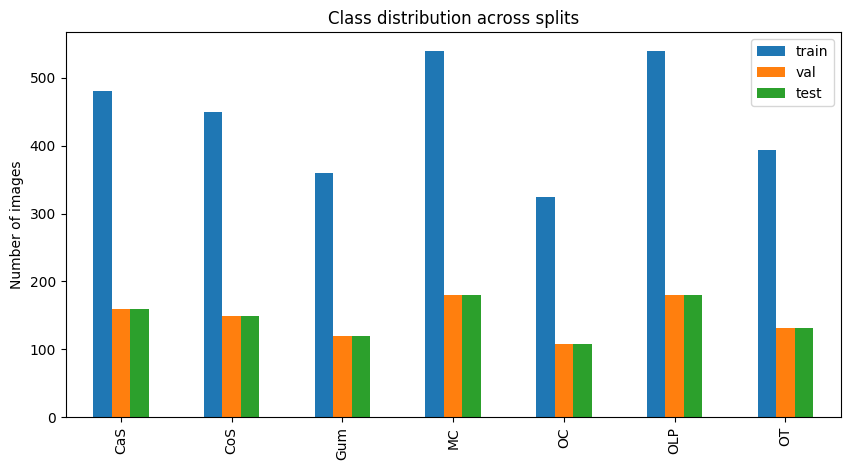

In [22]:
def dataset_class_distribution(ds):
    counts = {c:0 for c in class_names}
    for images, labels in ds.unbatch().map(lambda x,y:(x,y)).batch(10000):
        for l in labels.numpy():
            counts[class_names[int(l)]] += 1
    return counts

train_counts = dataset_class_distribution(train_ds)
val_counts = dataset_class_distribution(val_ds)
test_counts = dataset_class_distribution(test_ds)

dist_df = pd.DataFrame([train_counts, val_counts, test_counts], index=["train","val","test"])
print(dist_df)

plt.figure(figsize=(10,4))
dist_df.T.plot(kind='bar', stacked=False, figsize=(10,5))
plt.title("Class distribution across splits")
plt.ylabel("Number of images")
plt.show()

In [23]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation",
)


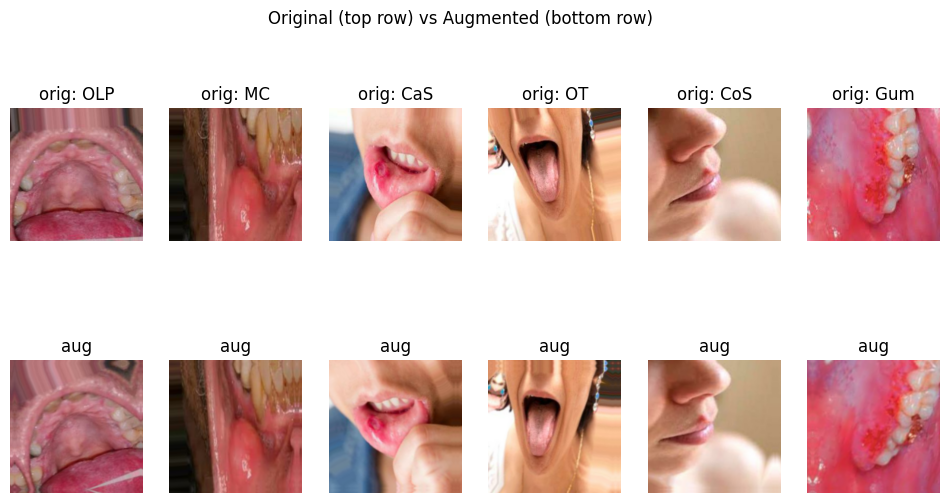

In [24]:

plt.figure(figsize=(12,6))
for images, labels in train_ds.take(1):
    images = images[:6]
    labels = labels[:6]
    for i in range(6):
        ax = plt.subplot(2,6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"orig: {class_names[labels[i]]}")
        plt.axis("off")

    aug_images = data_augmentation(images)
    for i in range(6):
        ax = plt.subplot(2,6, 6+i+1)
        plt.imshow(aug_images[i].numpy().astype("uint8"))
        ax.set_title("aug")
        plt.axis("off")
plt.suptitle("Original (top row) vs Augmented (bottom row)")
plt.show()

In [25]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x,y: (normalization_layer(x), y))

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [26]:
def create_model(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(265, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="teeth_cnn")
    return model

model = create_model()
model.summary()

Model: "teeth_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 265)    │       305,545 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 265)    │         1,060 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 265)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 265)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 444,276 (1.69 MB)

 Trainable params: 442,914 (1.69 MB)

 Non-trainable params: 1,362 (5.32 KB)

In [27]:
#initial_lr = 1e-3
model.compile(
    optimizer="Adam",
    #optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_path = "best_teeth_model.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=callbacks
)

Epoch 1/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.2196 - loss: 2.1924
Epoch 1: val_accuracy improved from None to 0.14494, saving model to best_teeth_model.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 207s 858ms/step - accuracy: 0.2559 - loss: 2.0256 - val_accuracy: 0.1449 - val_loss: 4.8719
Epoch 2/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.3408 - loss: 1.7389
Epoch 2: val_accuracy improved from 0.14494 to 0.16732, saving model to best_teeth_model.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 205s 863ms/step - accuracy: 0.3421 - loss: 1.7261 - val_accuracy: 0.1673 - val_loss: 2.9053
Epoch 3/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.3879 - loss: 1.6312
Epoch 3: val_accuracy improved from 0.16732 to 0.30156, saving model to best_teeth_model.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 206s 859ms/step - accuracy: 0.3810 - loss: 1.6287 - val_accuracy: 0.3016 - val_loss: 2.0984
Epoch 4/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.3976 - loss: 1.5753
Epoch 4: val_accuracy did not improve from 0.30156
193/193 ━━━━━━━━━━━━━━━━━━━━ 207s 866ms/step - accuracy: 0.4030 - loss: 1.5660 - val_accuracy: 0.1196 - val_loss: 5.3795
Epoch 5/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.4225 - loss: 1.4824
Epoch 5: val_accuracy did not improve from 0.30156
193/193 ━━━━━━━━━━━━━━━━━━━━ 202s 832ms/step - accuracy: 0.4351 - loss: 1.4529 - val_accuracy: 0.1440 - val_loss: 4.1929
Epoch 6/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.4715 - loss: 1.3957
Epoch 6: val_accuracy did not improve from 0.30156
193/193 ━━━━━━━━━━━━━━━━━━━━ 229s 952ms/step - accuracy: 0.4590 - loss: 1.4178 - val_accuracy: 0.2412 - val_loss: 2.3099
Epoch 7/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.5058 - loss: 1.3158
Epoch 7: va

193/193 ━━━━━━━━━━━━━━━━━━━━ 233s 960ms/step - accuracy: 0.5040 - loss: 1.3124 - val_accuracy: 0.3084 - val_loss: 2.1113
Epoch 8/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.5146 - loss: 1.2729
Epoch 8: val_accuracy improved from 0.30837 to 0.47179, saving model to best_teeth_model.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 223s 918ms/step - accuracy: 0.5228 - loss: 1.2617 - val_accuracy: 0.4718 - val_loss: 1.3966
Epoch 9/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5656 - loss: 1.1646
Epoch 9: val_accuracy did not improve from 0.47179
193/193 ━━━━━━━━━━━━━━━━━━━━ 209s 871ms/step - accuracy: 0.5607 - loss: 1.1764 - val_accuracy: 0.1459 - val_loss: 3.6117
Epoch 10/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.5715 - loss: 1.1488
Epoch 10: val_accuracy did not improve from 0.47179
193/193 ━━━━━━━━━━━━━━━━━━━━ 207s 865ms/step - accuracy: 0.5792 - loss: 1.1368 - val_accuracy: 0.3132 - val_loss: 2.4128
Epoch 11/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.6186 - loss: 1.0496
Epoch 11: val_accuracy did not improve from 0.47179
193/193 ━━━━━━━━━━━━━━━━━━━━ 202s 832ms/step - accuracy: 0.6035 - loss: 1.0702 - val_accuracy: 0.3064 - val_loss: 2.0252
Epoch 12/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.6194 - loss: 1.0555
Epoch 

193/193 ━━━━━━━━━━━━━━━━━━━━ 233s 957ms/step - accuracy: 0.6226 - loss: 1.0471 - val_accuracy: 0.5944 - val_loss: 1.0752
Epoch 13/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.6493 - loss: 0.9658
Epoch 13: val_accuracy did not improve from 0.59436
193/193 ━━━━━━━━━━━━━━━━━━━━ 266s 973ms/step - accuracy: 0.6456 - loss: 0.9637 - val_accuracy: 0.2626 - val_loss: 2.6551
Epoch 14/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.6443 - loss: 0.9573
Epoch 14: val_accuracy did not improve from 0.59436
193/193 ━━━━━━━━━━━━━━━━━━━━ 260s 959ms/step - accuracy: 0.6638 - loss: 0.9136 - val_accuracy: 0.5302 - val_loss: 1.2491
Epoch 15/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.6732 - loss: 0.8992
Epoch 15: val_accuracy improved from 0.59436 to 0.69261, saving model to best_teeth_model.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 215s 866ms/step - accuracy: 0.6877 - loss: 0.8695 - val_accuracy: 0.6926 - val_loss: 0.8935
Epoch 16/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.6973 - loss: 0.8078
Epoch 16: val_accuracy did not improve from 0.69261
193/193 ━━━━━━━━━━━━━━━━━━━━ 203s 840ms/step - accuracy: 0.7023 - loss: 0.8076 - val_accuracy: 0.6459 - val_loss: 0.9163
Epoch 17/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.7235 - loss: 0.7618
Epoch 17: val_accuracy did not improve from 0.69261
193/193 ━━━━━━━━━━━━━━━━━━━━ 242s 969ms/step - accuracy: 0.7243 - loss: 0.7762 - val_accuracy: 0.6323 - val_loss: 0.9646
Epoch 18/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.7331 - loss: 0.7224
Epoch 18: val_accuracy did not improve from 0.69261
193/193 ━━━━━━━━━━━━━━━━━━━━ 266s 964ms/step - accuracy: 0.7237 - loss: 0.7539 - val_accuracy: 0.4640 - val_loss: 1.7187
Epoch 19/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.7477 - loss: 0.7053
Epoc

193/193 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7548 - loss: 0.6779 - val_accuracy: 0.8132 - val_loss: 0.5222
Epoch 20/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7647 - loss: 0.6231
Epoch 20: val_accuracy did not improve from 0.81323
193/193 ━━━━━━━━━━━━━━━━━━━━ 263s 976ms/step - accuracy: 0.7736 - loss: 0.6127 - val_accuracy: 0.7471 - val_loss: 0.7452
Epoch 21/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.7587 - loss: 0.6574
Epoch 21: val_accuracy did not improve from 0.81323
193/193 ━━━━━━━━━━━━━━━━━━━━ 237s 976ms/step - accuracy: 0.7787 - loss: 0.6089 - val_accuracy: 0.6488 - val_loss: 0.9653
Epoch 22/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7746 - loss: 0.6085
Epoch 22: val_accuracy did not improve from 0.81323
193/193 ━━━━━━━━━━━━━━━━━━━━ 210s 883ms/step - accuracy: 0.7865 - loss: 0.5836 - val_accuracy: 0.5642 - val_loss: 1.3044
Epoch 23/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.8105 - loss: 0.5518
Epoch 2

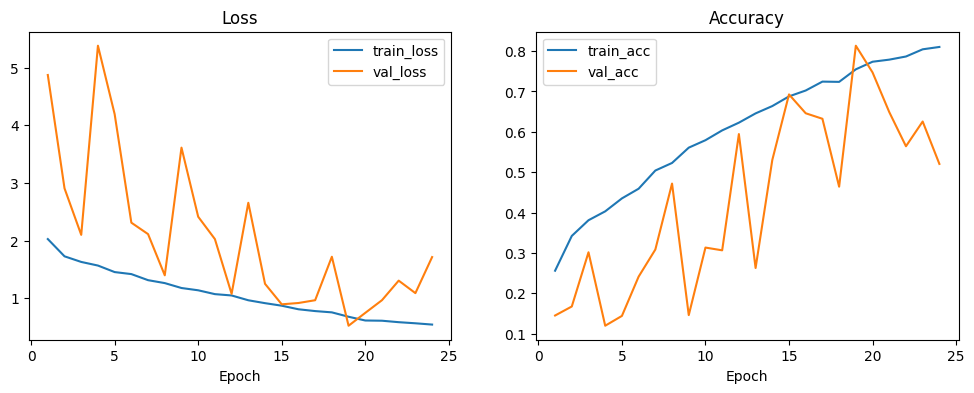

In [32]:
def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)

In [33]:
test_acc,test_loss = model.evaluate(test_ds)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.8259 - loss: 0.4986
Test accuracy: 0.4986374080181122
Test loss: 0.825875461101532


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

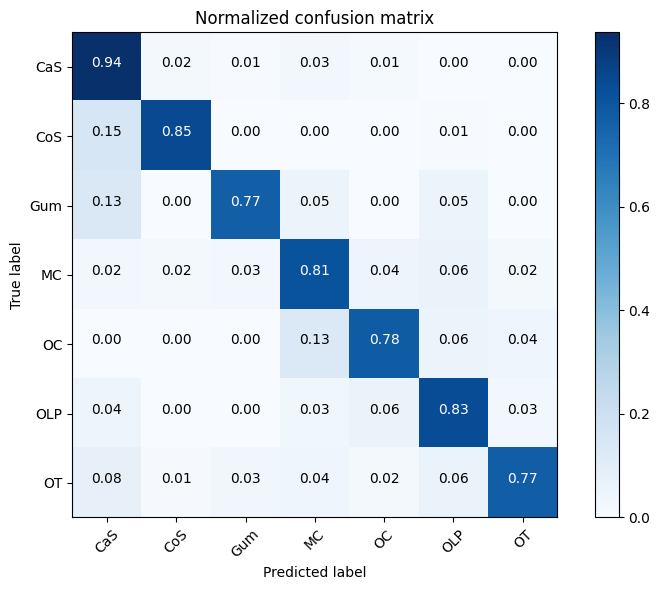

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
model.load_weights(checkpoint_path)

y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    if normalize:
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cmn = cm
    plt.imshow(cmn, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cmn.max() / 2.
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
        plt.text(j, i, format(cmn[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cmn[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

In [34]:
model.save("final_teeth_model.h5")